In [325]:
from datetime import date, timedelta, timezone
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import util
import os

download the model, then download the next 7 days weather forecast -make prediction, and dashboard

In [326]:
today = datetime.now() - timedelta(0)
tomorrow = today + timedelta(days = 1)
today

datetime.datetime(2024, 11, 17, 21, 31, 17, 508810)

In [327]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
url=location['aqicn_url']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [328]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

Model registry

In [329]:
mr= project.get_model_registry()

retrieved_model=mr.get_model(
    name="air_quality_xgboost_model",
    version=6,
)

saved_model_dir=retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [330]:
retrieved_xgboost_model=XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir+"/model.json")

retrieved_xgboost_model

XGBRegressor(base_score='2.4931547E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [333]:
weather_fg= fs.get_feature_group(
    name='weather',
    version=1,
)

batch_data= weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date']).reset_index(drop=True)

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-17 00:00:00+00:00,6.05,0.0,16.071491,254.407120,stockholm
1,2024-11-18 00:00:00+00:00,3.30,0.0,8.557102,292.249084,stockholm
2,2024-11-19 00:00:00+00:00,2.45,0.0,1.800000,143.130020,stockholm
3,2024-11-20 00:00:00+00:00,5.70,2.5,13.044722,140.599365,stockholm
4,2024-11-21 00:00:00+00:00,3.30,0.2,14.145756,165.256393,stockholm
5,2024-11-22 00:00:00+00:00,2.35,0.1,13.044724,242.020615,stockholm
6,2024-11-23 00:00:00+00:00,-0.35,0.0,9.504273,245.376450,stockholm
7,2024-11-24 00:00:00+00:00,-1.60,0.0,10.853866,275.710510,stockholm


In [342]:
air_quality_fg= fs.get_feature_group(
    name='air_quality',
    version=1,
)

today=datetime.today() - timedelta(1)       #Ändra att ta bort en dag för att bli av med timmar, av någon anleedning funkar det inte med raden under

aq_batch_data= air_quality_fg.filter(air_quality_fg.date >= today).read()       #Only need todays for future predictions. Makes it a dataframe
aq_batch_data = aq_batch_data.sort_values(by=['date']).reset_index(drop=True)

df_combined = pd.concat([aq_batch_data, batch_data], ignore_index=True)

for index in range(len(batch_data)-1):        
    current_day=df_combined.loc[index,['date']]

    df_combined.at[index+1,'pm25_3_days_before']=df_combined.loc[index,'pm25_2_days_before']
    df_combined.at[index+1,'pm25_2_days_before']=df_combined.loc[index,'pm25_1_day_before']
    df_combined.at[index+1,'pm25_1_day_before']=df_combined.loc[index,'pm25']
    df_combined.at[index+1,'pm25_average_before']=df_combined.loc[index, ["pm25_1_day_before", "pm25_2_days_before", "pm25_3_days_before"]].mean().astype('float32')

    df_combined.at[index+1,"country"] = country
    df_combined.at[index+1,"street"] = street

    df_combined.at[index+1,"url"] = country
    #df["url"] = aqicn_url
    
    current_features=df_combined.loc[index+1, ['pm25_1_day_before', 'pm25_2_days_before','pm25_3_days_before','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]

    current_features = pd.DataFrame(current_features.astype(float)).T

    next_pred=retrieved_xgboost_model.predict(current_features)
    df_combined.at[index+1,'pm25']=next_pred
    batch_data.at[index, 'predicted_pm25']=next_pred

df_combined.dropna(inplace=True)        #Remove the first date, today - as it already is registered.
df_combined.info()

air_quality_fg.insert(df_combined[['city','country','date','pm25','pm25_1_day_before', 'pm25_2_days_before','pm25_3_days_before','pm25_average_before','street','url',]])  #insert air quality to feature store    

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 
<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 1 to 7
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         7 non-null      datetime64[us, UTC]
 1   pm25                         7 non-null      float32            
 2   country                      7 non-null      object             
 3   city                         7 non-null      object             
 4   street                       7 non-null      object             
 5   url                          7 non-null      object             
 6   pm25_1_day_before            7 non-null      float32            
 7   pm25_2_days_before           7 non-null      float32            
 8   pm25_3_days_before           7 non-null      float32            
 9   pm25_average_before          7 non-null    

Uploading Dataframe: 0.00% |          | Rows 0/7 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1169559/jobs/named/air_quality_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1411ccd90>,
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "pm25_2_days_before",
           "min_value": -0.1,
           "max_value": 500.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 672781
         }
       },
       "result": {
         "observed_value": 12.999999046325684,
         "element_count": 7,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024-11-17T08:43:30.000801Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     },
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min

In [350]:
df_combined.head()


,date,pm25,country,city,street,url,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,pm25_average_before,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25
1,2024-11-17 00:00:00+00:00,18.061663,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,15.000000,13.000000,22.000000,20.000000,6.05,0.0,16.071491,254.407120,18.061663
2,2024-11-18 00:00:00+00:00,26.580223,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,18.061663,15.000000,13.000000,16.666666,3.30,0.0,8.557102,292.249084,26.580223
3,2024-11-19 00:00:00+00:00,42.426304,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,26.580223,18.061663,15.000000,15.353887,2.45,0.0,1.800000,143.130020,42.426304
4,2024-11-20 00:00:00+00:00,47.899261,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,42.426304,26.580223,18.061663,19.880629,5.70,2.5,13.044722,140.599365,47.899261
5,2024-11-21 00:00:00+00:00,37.506947,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,47.899261,42.426304,26.580223,29.022730,3.30,0.2,14.145756,165.256393,37.506947


In [351]:
batch_data.head()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-17 00:00:00+00:00,6.05,0.0,16.071491,254.407120,stockholm,18.061663
1,2024-11-18 00:00:00+00:00,3.30,0.0,8.557102,292.249084,stockholm,26.580223
2,2024-11-19 00:00:00+00:00,2.45,0.0,1.800000,143.130020,stockholm,42.426304
3,2024-11-20 00:00:00+00:00,5.70,2.5,13.044722,140.599365,stockholm,47.899261
4,2024-11-21 00:00:00+00:00,3.30,0.2,14.145756,165.256393,stockholm,37.506947


In [352]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-17 00:00:00+00:00,6.05,0.0,16.071491,254.407120,stockholm,18.061663,stockholm-st-eriksgatan-83,sweden,1
1,2024-11-18 00:00:00+00:00,3.30,0.0,8.557102,292.249084,stockholm,26.580223,stockholm-st-eriksgatan-83,sweden,2
2,2024-11-19 00:00:00+00:00,2.45,0.0,1.800000,143.130020,stockholm,42.426304,stockholm-st-eriksgatan-83,sweden,3
3,2024-11-20 00:00:00+00:00,5.70,2.5,13.044722,140.599365,stockholm,47.899261,stockholm-st-eriksgatan-83,sweden,4
4,2024-11-21 00:00:00+00:00,3.30,0.2,14.145756,165.256393,stockholm,37.506947,stockholm-st-eriksgatan-83,sweden,5
5,2024-11-22 00:00:00+00:00,2.35,0.1,13.044724,242.020615,stockholm,39.001717,stockholm-st-eriksgatan-83,sweden,6
6,2024-11-23 00:00:00+00:00,-0.35,0.0,9.504273,245.376450,stockholm,41.319893,stockholm-st-eriksgatan-83,sweden,7
7,2024-11-24 00:00:00+00:00,-1.60,0.0,10.853866,275.710510,stockholm,NaN,stockholm-st-eriksgatan-83,sweden,8


In [353]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               7 non-null      float32            
 7   street                       8 non-null      object             
 8   country                      8 non-null      object             
 9   days_before_forecast_day     8 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), objec

In [360]:
# Fill in the number of days before the date on which you made the forecast (base_date)
df_combined['days_before_forecast_day'] = range(1, len(batch_data))
df_combined = df_combined.sort_values(by=['date'])
df_combined

,date,pm25,country,city,street,url,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,pm25_average_before,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,days_before_forecast_day
1,2024-11-17 00:00:00+00:00,18.061663,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,15.000000,13.000000,22.000000,20.000000,6.05,0.0,16.071491,254.407120,18.061663,1
2,2024-11-18 00:00:00+00:00,26.580223,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,18.061663,15.000000,13.000000,16.666666,3.30,0.0,8.557102,292.249084,26.580223,2
3,2024-11-19 00:00:00+00:00,42.426304,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,26.580223,18.061663,15.000000,15.353887,2.45,0.0,1.800000,143.130020,42.426304,3
4,2024-11-20 00:00:00+00:00,47.899261,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,42.426304,26.580223,18.061663,19.880629,5.70,2.5,13.044722,140.599365,47.899261,4
5,2024-11-21 00:00:00+00:00,37.506947,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,47.899261,42.426304,26.580223,29.022730,3.30,0.2,14.145756,165.256393,37.506947,5
6,2024-11-22 00:00:00+00:00,39.001717,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,37.506947,47.899261,42.426304,38.968594,2.35,0.1,13.044724,242.020615,39.001717,6
7,2024-11-23 00:00:00+00:00,41.319893,sweden,stockholm,stockholm-st-eriksgatan-83,sweden,39.001717,37.506947,47.899261,42.610836,-0.35,0.0,9.504273,245.376450,41.319893,7


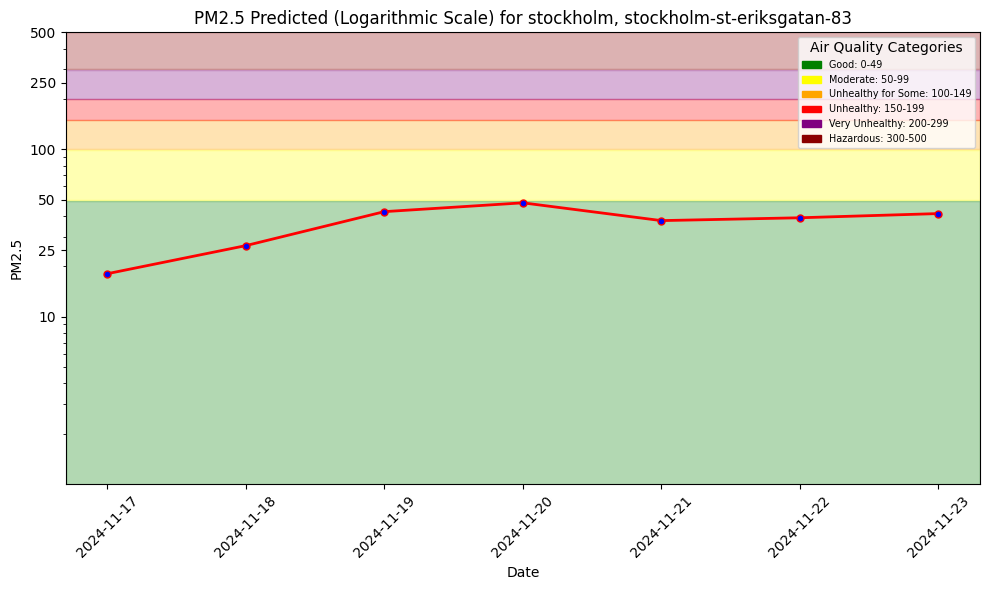

In [361]:
file_path = "docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, df_combined, file_path)
plt.show()

In [362]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [365]:
df_combined=df_combined.drop(['pm25_average_before','url'], axis=1)
print(df_combined.head())
monitor_fg.insert(df_combined, write_options={"wait_for_job": True})

                       date       pm25 country       city  \
1 2024-11-17 00:00:00+00:00  18.061663  sweden  stockholm   
2 2024-11-18 00:00:00+00:00  26.580223  sweden  stockholm   
3 2024-11-19 00:00:00+00:00  42.426304  sweden  stockholm   
4 2024-11-20 00:00:00+00:00  47.899261  sweden  stockholm   
5 2024-11-21 00:00:00+00:00  37.506947  sweden  stockholm   

                       street  pm25_1_day_before  pm25_2_days_before  \
1  stockholm-st-eriksgatan-83          15.000000           13.000000   
2  stockholm-st-eriksgatan-83          18.061663           15.000000   
3  stockholm-st-eriksgatan-83          26.580223           18.061663   
4  stockholm-st-eriksgatan-83          42.426304           26.580223   
5  stockholm-st-eriksgatan-83          47.899261           42.426304   

   pm25_3_days_before  temperature_2m_mean  precipitation_sum  \
1           22.000000                 6.05                0.0   
2           13.000000                 3.30                0.0   
3    

Uploading Dataframe: 0.00% |          | Rows 0/7 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1169559/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1402ca740>, None)

In [366]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.07s) 


,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,date,street,city,country,days_before_forecast_day,predicted_pm25
0,7.40,0.0,9.904906,250.906403,25.000000,25.0,21.0,21.0,2024-11-15 00:00:00+00:00,stockholm-st-eriksgatan-83,stockholm,sweden,1,25.000000
1,6.05,0.0,16.071491,254.407120,18.061663,15.0,13.0,22.0,2024-11-17 00:00:00+00:00,stockholm-st-eriksgatan-83,stockholm,sweden,1,18.061663


In [367]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.84s) 


,date,pm25,country,city,street,url,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,pm25_average_before
0,2021-06-27 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,27.0,37.0,26.0,30.000000
1,2023-12-15 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,21.0,25.0,21.666666
2,2024-09-22 00:00:00+00:00,10.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,23.0,24.0,22.000000
3,2021-11-09 00:00:00+00:00,20.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,14.0,9.0,13.0,12.000000
4,2021-04-24 00:00:00+00:00,9.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,12.0,17.0,26.0,18.333334
...,...,...,...,...,...,...,...,...,...,...
2134,2019-03-24 00:00:00+00:00,25.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,31.0,28.0,26.0,28.333334
2135,2020-03-13 00:00:00+00:00,17.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,16.0,26.0,33.0,25.000000
2136,2021-01-18 00:00:00+00:00,26.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,18.0,16.0,20.0,18.000000
2137,2024-11-17 00:00:00+00:00,15.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,13.0,22.0,25.0,20.000000


In [370]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-15 00:00:00+00:00,25.000000,22.0
1,2024-11-17 00:00:00+00:00,18.061663,15.0


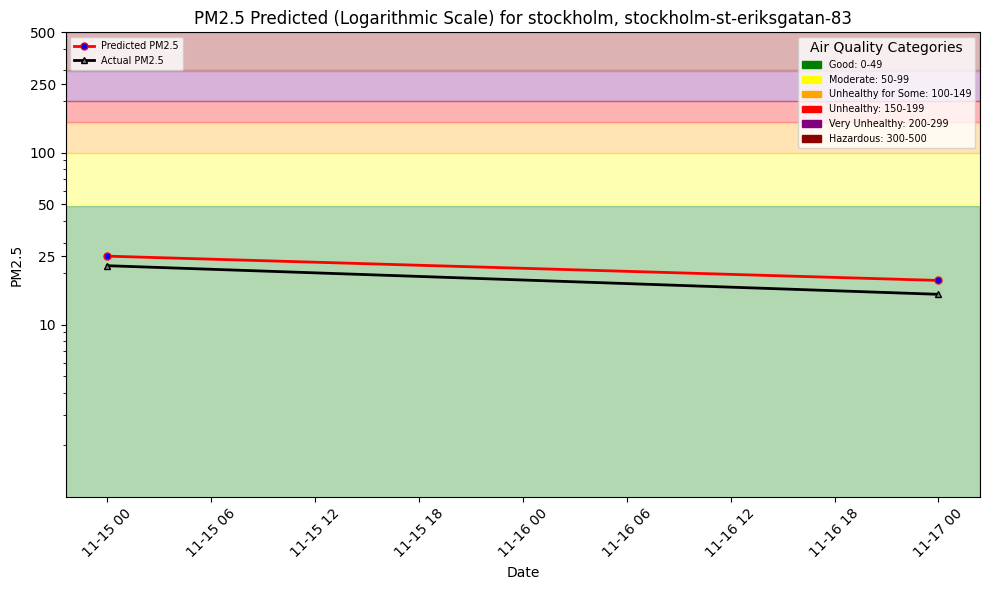

In [369]:
file_path = "docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()